In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats

from mplsoccer import Pitch

from PIL import Image
import urllib
import os
import json

In [672]:
path_to_json_matches = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\matchdata' 
path_to_json_minutesdata = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\playerdata'

# find all .json extensions in a specific directory and assign to one of three lists (matches, players, metadata)
json_files_matches = [pos_json for pos_json in os.listdir(path_to_json_matches) if pos_json.endswith('.json')]
json_file_minutesdata = [pos_json for pos_json in os.listdir(path_to_json_players) if pos_json.endswith('.json')]

In [673]:
# Collect all matches from directory in a dataframe
all_matches = []

for i in list(range(0,len(json_files_matches))):
  dir = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\matchdata' 
  f = open (dir + '/' + json_files_matches[i])  
  matches = json.loads(f.read()) 
  matches = pd.DataFrame(matches['events']) 
  all_matches.append(matches)
all_matches_df = pd.concat(all_matches)

# Collect the ID for a specific tournament and match
dir = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\playerdata'
f = open (dir + '/' + json_file_minutesdata[0])
minutesdata = json.loads(f.read())
minutesdata = pd.DataFrame(minutesdata)

In [674]:
# Filter the DataFrame to keep only the rows with the desired 'minutes' key
minutesdata = minutesdata[minutesdata['minutes'].apply(lambda x: '642d59154919e45244efd35b' in x)]

# Reset the index of the cleaned DataFrame
minutesdata = minutesdata.reset_index(drop=True)

# Define a function to extract the minutes from the nested dictionary
def extract_minutes(row):
    minutes_dict = row.get("minutes", {}).get("642d59154919e45244efd35b", {})
    minutes_sum = sum(minutes_dict.values())
    return minutes_sum

# Apply the function to create a new column containing the sum of minutes
minutesdata["minutes_sum"] = minutesdata.apply(extract_minutes, axis=1)


In [675]:
# rename the minutesdata name column to player
minutesdata = minutesdata.rename(columns={'name': 'player'})

In [676]:
dribble_df = all_matches_df.loc[(all_matches_df['action'] == 'Dribble successful') | (all_matches_df['action'] == 'Dribble unsuccessful')]

In [677]:
dribble_df = dribble_df[['player', 'team', 'action', 'xpos', 'ypos', 'xdest', 'ydest']].copy()

In [678]:
# Count the number of successful and unsuccessful dribbles for each player
# dribble_counts = dribble_df.groupby('player')['action'].value_counts().unstack().fillna(0)
dribble_counts = dribble_df.groupby(['player', 'team'])['action'].value_counts().unstack().fillna(0)

# Calculate the success rate
dribble_counts['success_rate'] = dribble_counts['Dribble successful'] / (dribble_counts['Dribble successful'] + dribble_counts['Dribble unsuccessful'])

In [679]:
# Merge based on 'player' column
merged_df = dribble_counts.merge(minutesdata, left_on='player', right_on='player', how='left')

In [680]:
# Create a dictionary to map 'friendly_name' to 'player'
nickname_map = minutesdata.set_index('friendly_name')['player'].to_dict()
# Create a mask for rows where the merge on 'player' column did not find a match
mask = merged_df['minutes_sum'].isnull()
# Map 'player' column using the nickname_map for unmatched rows
merged_df.loc[mask, 'player'] = merged_df.loc[mask, 'player'].map(nickname_map)
# Merge based on 'player' column
merged_df = merged_df.merge(minutesdata, left_on='player', right_on='player', how='left')

In [681]:
# Drop unnecessary columns
merged_df = merged_df.drop(columns=['minutes_x', 'minutes_sum_x', 'friendly_name_x', 'team_x', 'friendly_name_y', 'minutes_y'])

In [682]:
# Remove "_x" and "_y" from column names
merged_df = merged_df.rename(columns=lambda x: x.rstrip('_x').rstrip('_y'))

In [683]:
(df_plot['Dribble successful'] + df_plot['Dribble unsuccessful']).median()

6.0

In [684]:
df_plot = merged_df[
    (merged_df['minutes_sum'] >= merged_df['minutes_sum'].median()) &
    (merged_df['Dribble successful'] + merged_df['Dribble unsuccessful'] >= 4)
]

In [685]:
df_plot = df_plot.assign(succ_dribble_90=lambda x: ((x['Dribble successful'] + x['Dribble unsuccessful']) / x['minutes_sum']) * 90)

In [686]:
# Delete rows where player is unknown
df_plot = df_plot[df_plot['player'] != 'Unknown']

# Sort the DataFrame by 'succ_dribble_90' column in descending order
df_plot = df_plot.sort_values(by='succ_dribble_90', ascending=False)

In [687]:
# compute a basic z-score index for the colormap.
df_plot['zscore'] = stats.zscore(df_plot['succ_dribble_90'])*.4 + stats.zscore(df_plot['success_rate'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.95) else False for x in df_plot['zscore']]

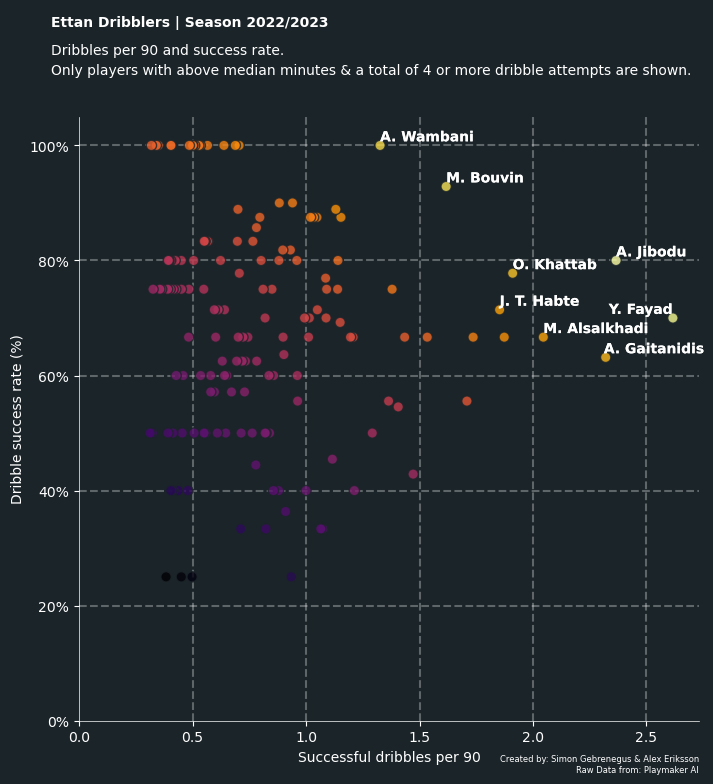

In [688]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from adjustText import adjust_text
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import AnchoredText

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_facecolor('#1b2429')

ax.scatter(
    df_plot['succ_dribble_90'], df_plot['success_rate'], 
    c=df_plot['zscore'], cmap='inferno', 
    zorder=3, ec='#1b2429', s=55, alpha=0.8)

texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    name_parts = annotated_df['player'].iloc[index].split()
    initials = " ".join(part[0] + "." for part in name_parts[:-1])
    last_name = name_parts[-1]
    
    texts += [
        ax.text(
            x=annotated_df['succ_dribble_90'].iloc[index], y=annotated_df['success_rate'].iloc[index],
            s=f"{initials} {last_name}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()),
                          path_effects.Normal()], color='white',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points': 'y', 'text': 'xy', 'objects': 'xy'})

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
x_ticks = [0, 0.5, 1, 1.5, 2, 2.5]
ax.set_xticks(x_ticks)

max_success_rate = df_plot['success_rate'].max()
space_above_100 = 0.05
y_upper_limit = 1.05

ax.set_ylim(0, y_upper_limit)
ax.set_yticks(np.linspace(0, 1.0, 6))

ax.spines['top'].set_visible(False)
ax.axvline(x=0.5, color='white', linestyle='--', alpha = 0.3)
ax.axvline(x=1.0, color='white', linestyle='--', alpha = 0.3)
ax.axvline(x=1.5, color='white', linestyle='--', alpha = 0.3)
ax.axvline(x=2.0, color='white', linestyle='--', alpha = 0.3)
ax.axvline(x=2.5, color='white', linestyle='--', alpha = 0.3)
ax.axhline(y=1.0, color='white', linestyle='--', alpha = 0.3)
ax.axhline(y=0.8, color='white', linestyle='--', alpha = 0.3)
ax.axhline(y=0.6, color='white', linestyle='--', alpha = 0.3)
ax.axhline(y=0.4, color='white', linestyle='--', alpha = 0.3)
ax.axhline(y=0.2, color='white', linestyle='--', alpha = 0.3)

ax.set_ylabel('Dribble success rate (%)')
ax.set_xlabel('Successful dribbles per 90')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('#1b2429')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

fig.text(0.95, 0.9, '', transform=ax.transAxes, fontsize=5, ha='right', va='bottom', color="#BBBFCA")
ax.text(0.95, 0.8, '', transform=ax.transAxes, fontsize=5, ha='right', va='bottom', color="#BBBFCA")


fig_text(
    x=0.09, y=.99,
    s="Ettan Dribblers | Season 2022/2023",
    va="bottom", ha="left",
    fontsize=20, color="white", font="DM Sans", weight="bold"
)

fig_text(
    x=0.09, y=0.93,
    s="Dribbles per 90 and success rate.\nOnly players with above median minutes & a total of 4 or more dribble attempts are shown.",
    va="bottom", ha="left",
    fontsize=12, color="white", font="Karla"
)

# Add creator text outside the plotted graph
plt.text(1, -0.085, "Created by: Simon Gebrenegus & Alex Eriksson\nRaw Data from: Playmaker AI", fontsize=6, color="white", ha="right", transform=ax.transAxes)


ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

plt.savefig(
    r'C:\Users\al.eriksson\Documents\Python\Football\dotplot_dribblers.jpg',
    dpi=600,
    facecolor='#1b2429',
    bbox_inches="tight",
    edgecolor='#1b2429',
    transparent=False
)

plt.show()
